<a href="https://colab.research.google.com/github/totti0223/deep_learning_for_biologists_with_keras/blob/master/notebooks/crop_weed_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Crop/Weed Field Image Dataset
https://github.com/cwfid/dataset

@inproceedings{haug15,
  author={Haug, Sebastian and Ostermann, J{\"o}rn},
  title={A Crop/Weed Field Image Dataset for the Evaluation of Computer Vision Based Precision Agriculture Tasks},
  year={2015},
  booktitle={Computer Vision - ECCV 2014 Workshops},
  doi={10.1007/978-3-319-16220-1_8},
  url={ http://dx.doi.org/10.1007/978-3-319-16220-1_8 },
  pages={105--116},
}


In [0]:
import os
import numpy as np

from skimage.io import imread
from skimage.transform import resize,rotate
from skimage.measure import find_contours
from skimage.util import invert
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
plt.style.use('default')

import keras.backend as K
import keras
from keras import layers, activations
from keras.models import Model
from keras.preprocessing.image import load_img,img_to_array
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Layer

from IPython.display import Image
import tensorflow as tf

import yaml

## Dataset download

In [2]:
!wget https://github.com/cwfid/dataset/archive/v1.0.tar.gz 
!tar -zxf v1.0.tar.gz

--2019-01-12 08:43:52--  https://github.com/cwfid/dataset/archive/v1.0.tar.gz
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/cwfid/dataset/tar.gz/v1.0 [following]
--2019-01-12 08:43:52--  https://codeload.github.com/cwfid/dataset/tar.gz/v1.0
Resolving codeload.github.com (codeload.github.com)... 192.30.253.120, 192.30.253.121
Connecting to codeload.github.com (codeload.github.com)|192.30.253.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘v1.0.tar.gz.3’

v1.0.tar.gz.3           [               <=>  ]  86.12M  29.4MB/s    in 2.9s    

2019-01-12 08:43:55 (29.4 MB/s) - ‘v1.0.tar.gz.3’ saved [90303402]



In [3]:
!ls dataset-1.0

annotations  images  masks  README.md  train_test_split.yaml


In [4]:
for root, dirs, files in os.walk("dataset-1.0"):
    print(root)
    print(sorted(files))

dataset-1.0
['README.md', 'train_test_split.yaml']
dataset-1.0/annotations
['001_annotation.png', '001_annotation.yaml', '002_annotation.png', '002_annotation.yaml', '003_annotation.png', '003_annotation.yaml', '004_annotation.png', '004_annotation.yaml', '005_annotation.png', '005_annotation.yaml', '006_annotation.png', '006_annotation.yaml', '007_annotation.png', '007_annotation.yaml', '008_annotation.png', '008_annotation.yaml', '009_annotation.png', '009_annotation.yaml', '010_annotation.png', '010_annotation.yaml', '011_annotation.png', '011_annotation.yaml', '012_annotation.png', '012_annotation.yaml', '013_annotation.png', '013_annotation.yaml', '014_annotation.png', '014_annotation.yaml', '015_annotation.png', '015_annotation.yaml', '016_annotation.png', '016_annotation.yaml', '017_annotation.png', '017_annotation.yaml', '018_annotation.png', '018_annotation.yaml', '019_annotation.png', '019_annotation.yaml', '020_annotation.png', '020_annotation.yaml', '021_annotation.png', '0

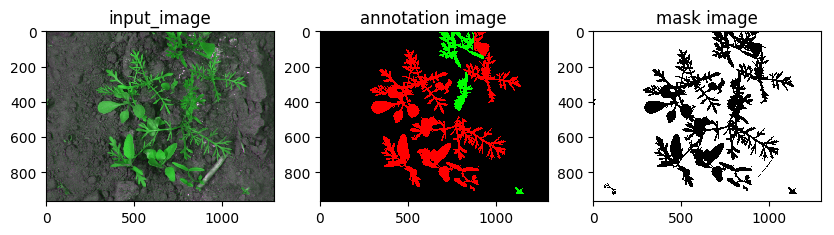

(966, 1296)


In [47]:
# red = weed, green = crop

pardir = "dataset-1.0"
img = imread(os.path.join(pardir,"images","001_image.png"))

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("input_image")
plt.imshow(img)

plt.subplot(1,3,2)
img = imread(os.path.join(pardir,"annotations","001_annotation.png"))
plt.title("annotation image")
plt.imshow(img)

plt.subplot(1,3,3)
img = imread(os.path.join(pardir,"masks","001_mask.png"))
plt.title("mask image")
plt.imshow(img,cmap="gray")
plt.show()
print(img.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(128, 128)


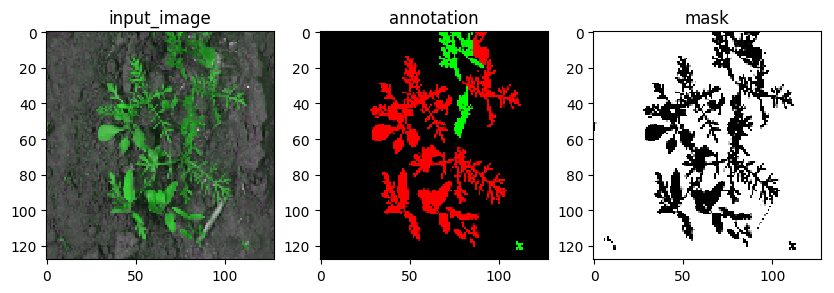

In [25]:
#for training speed, will resize it to 128, 128

pardir = "dataset-1.0"
img = imread(os.path.join(pardir,"images","001_image.png"))
img = resize(img,(128,128))

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("input_image")
plt.imshow(img)

img = imread(os.path.join(pardir,"annotations","001_annotation.png"))
img = resize(img,(128,128))

plt.subplot(1,3,2)
plt.title("annotation")
plt.imshow(img)

img = imread(os.path.join(pardir,"masks","001_mask.png"))
img = resize(img,(128,128))

plt.subplot(1,3,3)
plt.title("mask")
plt.imshow(img,cmap="gray")

print(img.shape)

## Region Segmentation (plant region isolation)
mask画像を使い、背景から植物のみを抽出するネットワークを作成します

### u-net model preparation
image from https://cdn.clipkit.co/tenants/86/item_images/images/000/003/918/medium/e9d88fd4-6844-46c4-9c79-dc39d1dafbc0.png?1544165126

![image](https://cdn.clipkit.co/tenants/86/item_images/images/000/003/918/medium/e9d88fd4-6844-46c4-9c79-dc39d1dafbc0.png?1544165126)

In [0]:
#戸田が適当に定義したU-Net
#学習時間の短縮のため、上記ネットワークを参照にして小さいunetネットワークを組んだ

def small_Unet(labels=1,h=128,w=128, out_activation = "sigmoid"):
    
    class MySoftmax(Layer):
        #http://cookie-box.hatenablog.com/entry/2017/08/15/231503 
        def __init__(self, **kwargs):
            super(MySoftmax, self).__init__(**kwargs)
        def call(self, x):
            return(activations.softmax(x, axis=3))

    
    
    #block1, 128x128
    inputs = layers.Input(shape=(h,w,3))
    conv11 = layers.Conv2D(16,(3,3),activation="relu",padding="same")(inputs)
    conv12= layers.Conv2D(16,(3,3),activation="relu",padding="same")(conv11)
    conv13= layers.Conv2D(16,(3,3),activation="relu",padding="same")(conv12)
    pool1 = layers.MaxPool2D((2,2))(conv13)
    drop1 = layers.Dropout(0.4)(pool1)
   #block2 64x64
    conv21 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(drop1)
    conv22 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(conv21)
    conv23 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(conv22)
    pool2 = layers.MaxPool2D((2,2))(conv23)
    drop2 = layers.Dropout(0.4)(pool2)
    #block3 32x32
    conv31 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(drop2)
    conv32 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(conv31)
    conv33 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(conv32)
    pool3 = layers.MaxPool2D((2,2))(conv33)
    drop3 = layers.Dropout(0.4)(pool3)

    #block4 16x16
    conv41 = layers.Conv2D(128,(3,3),activation="relu",padding="same")(drop3)
    conv42 = layers.Conv2D(128,(3,3),activation="relu",padding="same")(conv41)
    conv43 = layers.Conv2D(128,(3,3),activation="relu",padding="same")(conv42)
    pool4 = layers.MaxPool2D((2,2))(conv43)
    drop4 = layers.Dropout(0.4)(pool4)
    
    #bottom of Unet 8x8
    #下記のように、名前は一緒でも継承されるので問題ない。上をわけているのはclarityのため
    conv5 = layers.Conv2D(256,(3,3),activation="relu",padding="same")(drop4)
    conv5 = layers.Conv2D(256,(3,3),activation="relu",padding="same")(conv5)
    
    
    #以下、layerごとに固有の名前をつけるのは省略

    #upblock4
    x = layers.UpSampling2D((2,2))(conv5)
    x = layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv43,x])
    x= layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.4)(x)
    #upblock3
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv33,x])
    x= layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.4)(x)
    #upblock2
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv23,x])
    x= layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.4)(x)
    #upblock1
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv13,x])
    x= layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.4)(x)
    #to label image (2 labels)
    x = layers.Conv2D(labels,(1,1))(x)
    if out_activation == "sigmoid":
        outputs = layers.Activation("sigmoid")(x)
    elif out_activation == "softmax":
        outputs =MySoftmax()(x)
    elif  out_activation == None:
        outputs = x
    model = Model(inputs=inputs,outputs=outputs)
    return model

In [0]:
K.clear_session()


model = small_Unet(labels=1)  


#https://stackoverflow.com/questions/49785133/keras-dice-coefficient-loss-function-is-negative-and-increasing-with-epochs

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2.0 * intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


model.compile(loss=dice_coef_loss,optimizer="rmsprop")

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_poolin

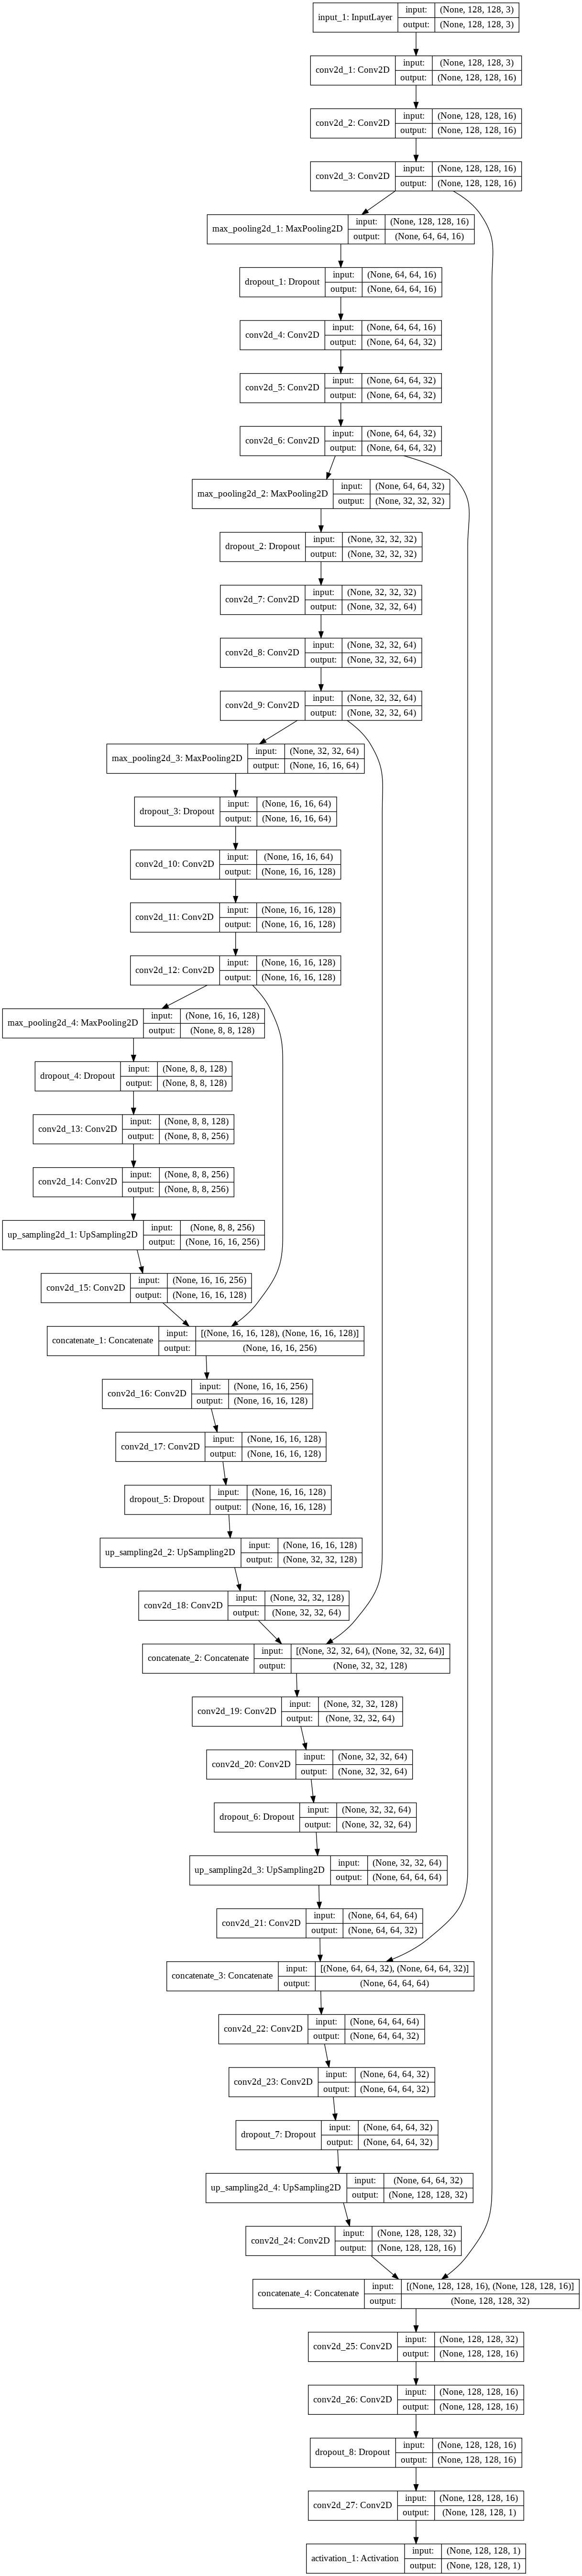

In [29]:
#alternative visualization of model structure
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

Image("model_plot.png")

### data preparation

In [30]:
#まずはフォルダの構造を確認
for root, dirs, files in os.walk("dataset-1.0"):
    print(root)
    print(sorted(files))

print("\n")
    
with open("dataset-1.0/train_test_split.yaml","r") as f:
    data = yaml.load(f)

print(data)
print("train_data is:",data["train"])
print("test_data is:",data["test"])


dataset-1.0
['README.md', 'train_test_split.yaml']
dataset-1.0/annotations
['001_annotation.png', '001_annotation.yaml', '002_annotation.png', '002_annotation.yaml', '003_annotation.png', '003_annotation.yaml', '004_annotation.png', '004_annotation.yaml', '005_annotation.png', '005_annotation.yaml', '006_annotation.png', '006_annotation.yaml', '007_annotation.png', '007_annotation.yaml', '008_annotation.png', '008_annotation.yaml', '009_annotation.png', '009_annotation.yaml', '010_annotation.png', '010_annotation.yaml', '011_annotation.png', '011_annotation.yaml', '012_annotation.png', '012_annotation.yaml', '013_annotation.png', '013_annotation.yaml', '014_annotation.png', '014_annotation.yaml', '015_annotation.png', '015_annotation.yaml', '016_annotation.png', '016_annotation.yaml', '017_annotation.png', '017_annotation.yaml', '018_annotation.png', '018_annotation.yaml', '019_annotation.png', '019_annotation.yaml', '020_annotation.png', '020_annotation.yaml', '021_annotation.png', '0

In [48]:
#read image into memory

train_x = []
train_y = []
test_x = []
test_y = []


for number in data["train"]:
    #桁あわせ　ex. 1 to 001
    number = "{0:03d}".format(number)
    #入力画像の読み込み
    x_path = os.path.join("dataset-1.0","images",str.format(number)) + "_image.png" 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    train_x.append(img)
    
    #出力マスク画像の読み込み
    y_path = os.path.join("dataset-1.0","masks",str(number)) + "_mask.png" 
    img = load_img(y_path,target_size=(128,128),color_mode="grayscale")
    img = img_to_array(img,dtype="uint8")
    #白黒反転
    img = invert(img)/255.
    train_y.append(img)
    
    
for number in data["test"]:
    #桁あわせ　ex. 1 to 001
    number = "{0:03d}".format(number)
    #入力画像の読み込み
    x_path = os.path.join("dataset-1.0","images",str.format(number)) + "_image.png" 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    test_x.append(img)
    
    #出力マスク画像の読み込み
    y_path = os.path.join("dataset-1.0","masks",str(number)) + "_mask.png" 
    img = load_img(y_path,target_size=(128,128),color_mode="grayscale")
    img = img_to_array(img,dtype="uint8")
    #白黒反転
    img = invert(img)/255.
    test_y.append(img)

    
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)


#check shape
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(40, 128, 128, 3)
(40, 128, 128, 1)
(21, 128, 128, 3)
(21, 128, 128, 1)


### training

In [32]:
#(以下のようにvalidationにtest dataを当てるのは本当はよくありませんが、簡略化のため使用しています)
history = model.fit(train_x, train_y, batch_size=10, epochs=150,verbose=1,validation_data=(test_x,test_y))

Train on 40 samples, validate on 21 samples
Epoch 1/150
40/40 [==============================] - 2s 50ms/step - loss: 0.8558 - val_loss: 0.8520
Epoch 2/150
40/40 [==============================] - 0s 12ms/step - loss: 0.8463 - val_loss: 0.8182
Epoch 3/150
40/40 [==============================] - 0s 12ms/step - loss: 0.8206 - val_loss: 0.8208
Epoch 4/150
40/40 [==============================] - 0s 12ms/step - loss: 0.7925 - val_loss: 0.9999
Epoch 5/150
40/40 [==============================] - 0s 12ms/step - loss: 0.9335 - val_loss: 0.9999
Epoch 6/150
40/40 [==============================] - 0s 12ms/step - loss: 0.9210 - val_loss: 0.9999
Epoch 7/150
40/40 [==============================] - 0s 12ms/step - loss: 0.9053 - val_loss: 0.9999
Epoch 8/150
40/40 [==============================] - 0s 12ms/step - loss: 0.9047 - val_loss: 0.9999
Epoch 9/150
40/40 [==============================] - 0s 12ms/step - loss: 0.9119 - val_loss: 0.9999
Epoch 10/150
40/40 [==============================] - 0s

### use the model

IndexError: ignored

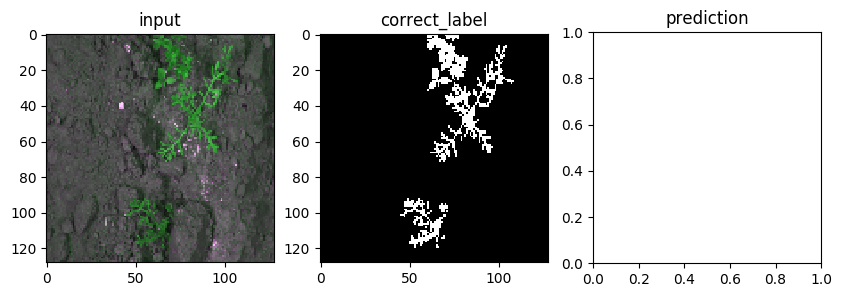

In [49]:
# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n = 4

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(1,3,2)
plt.title("correct_label")
plt.imshow(test_y[n,:,:,0],cmap="gray")


prediction = model.predict(test_x[n:n+1])
#prediction shape will be (1,128,128,1)

plt.subplot(1,3,3)
plt.title("prediction")
plt.imshow(prediction[0,:,:,0])

## Region Segmentation (crop weed segmentation)

### u-net model preparation

In [0]:
#今回は使わない。特殊なloss

#modified based on https://github.com/keras-team/keras/issues/9395

#---------------------------------------------------------------------------------------------------------------------#
#generalized dice loss
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=2):
    dice=0
    for index in range(numLabels):
        #dice -= dice_coef(y_true[:,index,:,:,:], y_pred[:,index,:,:,:])
        dice -= dice_coef(y_true[:, :, :, index], y_pred[:, :, :, index])
    return dice
#---------------------------------------------------------------------------------------------------------------------#
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
   #num = K.sum(p0*g0, (0,1,2,3))
    num = K.sum(p0*g0, (0,1,2))
    #den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T
#---------------------------------------------------------------------------------------------------------------------#


In [0]:
K.clear_session()

#pixel-wiseな正答率を出す簡便な方法
unet = small_Unet(labels=3,out_activation=None)  
l = layers.Reshape((128*128,3))(unet.output)
outs = layers.Activation("softmax")(l)

model = Model(inputs=unet.input,outputs=outs)

#model.compile(loss=dice_coef_multilabel,optimizer="rmsprop")
#model.compile(loss=tversky_loss,optimizer="rmsprop")
model.compile(loss="categorical_crossentropy",optimizer="rmsprop")

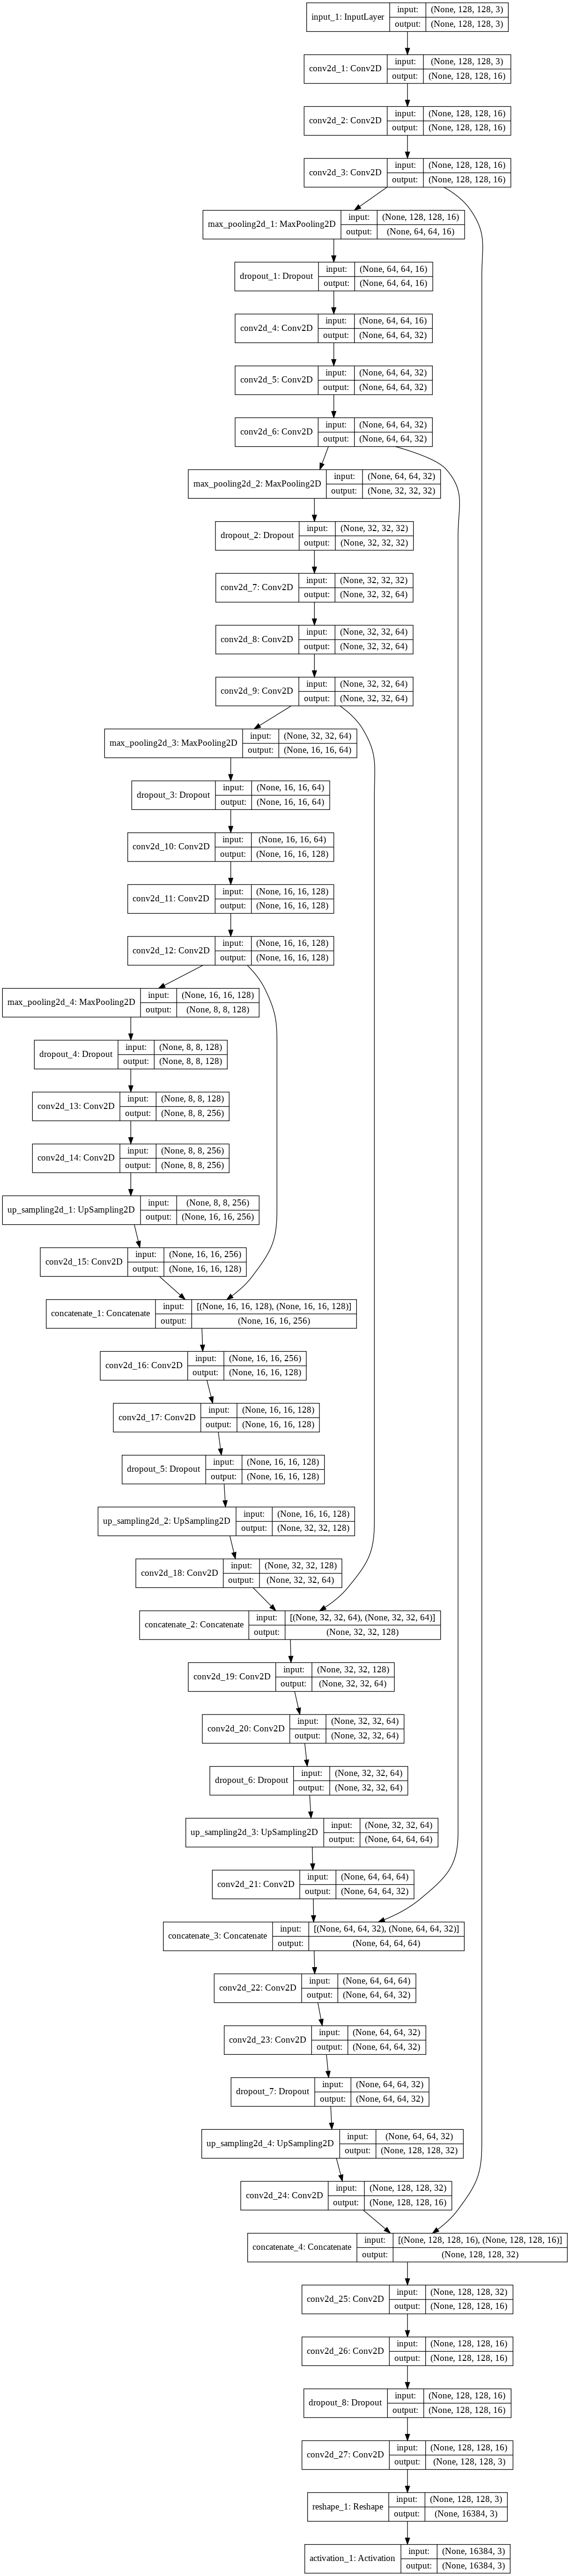

In [37]:
#alternative visualization of model structure
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

Image("model_plot.png")

### data preparation

今回のdatasetのshapeは、
(batch,height,width,label) = (1,128,128,2)
1label目はcrop、2 label目はweed。

In [50]:
#read image into memory

train_x = []
train_y = []
test_x = []
test_y = []


for number in data["train"]:
    #桁あわせ　ex. 1 to 001
    number = "{0:03d}".format(number)
    #入力画像の読み込み
    x_path = os.path.join("dataset-1.0","images",str.format(number)) + "_image.png" 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    train_x.append(img)
    
    #出力アノテーション画像の読み込み
    y_path = os.path.join("dataset-1.0","annotations",str(number)) + "_annotation.png" 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255

    #weedが赤、cropがgreenであり、image shape = r,g,bなのでsliceで対処
    #本来はデータ・セットのyamlの読み込みのコードを書くべきだが省略
    #３チャンネル目に背景のデータも入れる。
    
    weed = img[:,:,0]
    crop = img[:,:,1]

    y = np.zeros((128,128,3))
    y[:,:, 0] = weed
    y[:, :, 1] = crop
    
    #３チャンネル目に背景のデータも入れる。
    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1)*1
    y[:,:, 2] = back
    
    y = np.reshape(y,(128*128,3))
    
    train_y.append(y)
    
    
for number in data["test"]:
    #桁あわせ　ex. 1 to 001
    number = "{0:03d}".format(number)
    #入力画像の読み込み
    x_path = os.path.join("dataset-1.0","images",str.format(number)) + "_image.png" 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    test_x.append(img)
    
    #出力アノテーション画像の読み込み
    y_path = os.path.join("dataset-1.0","annotations",str(number)) + "_annotation.png" 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255
    
    #weedが赤、cropがgreenであり、image shape = r,g,bなのでsliceで対処
    #本来はデータ・セットのyamlの読み込みのコードを書くべきだが省略
    weed = img[:,:,0]
    crop = img[:,:,1]

    y = np.zeros((128,128,3))
    
    y[:,:, 0] = weed
    y[:, :,1] = crop

    #３チャンネル目に背景のデータも入れる。
    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1)*1
    y[:,:, 2] = back
    
    y = np.reshape(y,(128*128,3))
    test_y.append(y)

    
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

#check shape
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(40, 128, 128, 3)
(40, 16384, 3)
(21, 128, 128, 3)
(21, 16384, 3)


#### Inspect how the dataset was read

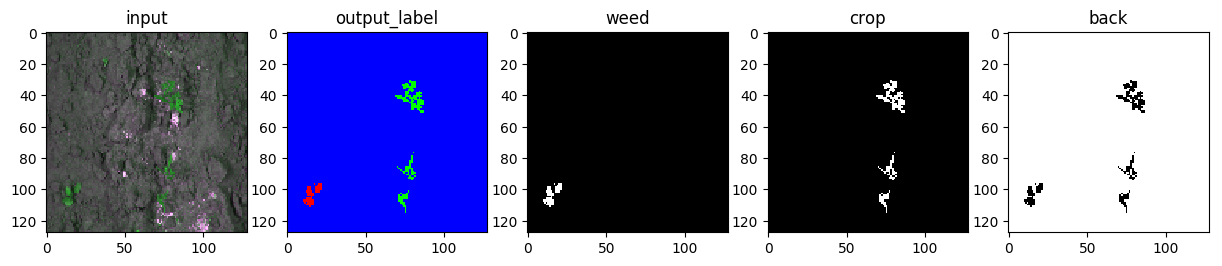

In [51]:
n = 12

plt.figure(figsize=(15,3))
plt.subplot(1,5,1)
plt.title("input")
plt.imshow(train_x[n])

plt.subplot(1,5,2)
plt.title("output_label")
img = np.reshape(train_y[n, :],(128,128,3))
plt.imshow(img,)

plt.subplot(1,5,3)
plt.title("weed")
img = np.reshape(train_y[n, :, 0],(128,128))
plt.imshow(img,cmap="gray")

plt.subplot(1,5,4)
plt.title("crop")
img = np.reshape(train_y[n, :, 1],(128,128))
plt.imshow(img,cmap="gray")

plt.subplot(1,5,5)
plt.title("back")
img = np.reshape(train_y[n, :, 2],(128,128))
plt.imshow(img,cmap="gray")

### training

In [42]:
history = model.fit(train_x, train_y, batch_size=10, epochs=150, verbose=1,validation_data=(test_x,test_y))

Train on 40 samples, validate on 21 samples
Epoch 1/150
40/40 [==============================] - 2s 56ms/step - loss: 1.5353 - val_loss: 0.5557
Epoch 2/150
40/40 [==============================] - 1s 13ms/step - loss: 0.6665 - val_loss: 0.3989
Epoch 3/150
40/40 [==============================] - 0s 12ms/step - loss: 0.5029 - val_loss: 0.4050
Epoch 4/150
40/40 [==============================] - 0s 12ms/step - loss: 0.4411 - val_loss: 0.4309
Epoch 5/150
40/40 [==============================] - 0s 12ms/step - loss: 0.4228 - val_loss: 0.3197
Epoch 6/150
40/40 [==============================] - 0s 12ms/step - loss: 0.3723 - val_loss: 0.3237
Epoch 7/150
40/40 [==============================] - 0s 12ms/step - loss: 0.3548 - val_loss: 0.2734
Epoch 8/150
40/40 [==============================] - 1s 13ms/step - loss: 0.2923 - val_loss: 0.1979
Epoch 9/150
40/40 [==============================] - 1s 13ms/step - loss: 0.2917 - val_loss: 0.2416
Epoch 10/150
40/40 [==============================] - 1s

### evaluation

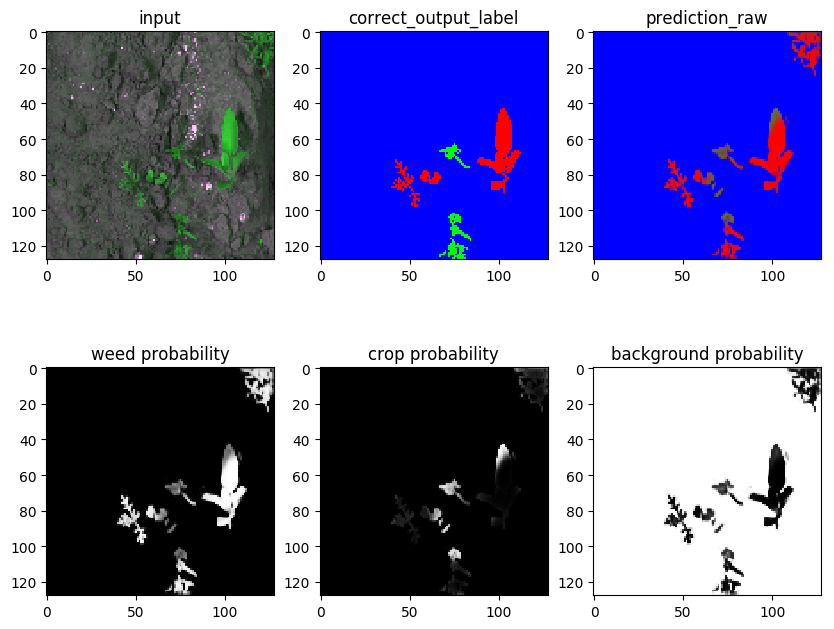

In [176]:
# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n = 6

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(2,3,2)
plt.title("correct_output_label")
img = np.reshape(test_y[n, :],(128,128,3))
plt.imshow(img)

prediction = model.predict(test_x[n:n+1])
prediction = np.reshape(prediction,(128,128,3))
plt.subplot(2,3,3)
plt.title("prediction_raw")
plt.imshow(prediction)


#per label
plt.subplot(2,3,4)
plt.title("weed probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 0 ,axis=-1)*1
plt.imshow(prediction[:,:,0],cmap="gray")

plt.subplot(2,3,5)
plt.title("crop probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 1 ,axis=-1)*1
plt.imshow(prediction[:,:,1],cmap="gray")

plt.subplot(2,3,6)
plt.title("background probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 2 ,axis=-1)*1
plt.imshow(prediction[:,:,2],cmap="gray")

## Resolving class imblance

38426.0
10319.0
606615


Text(0,0.5,'px')

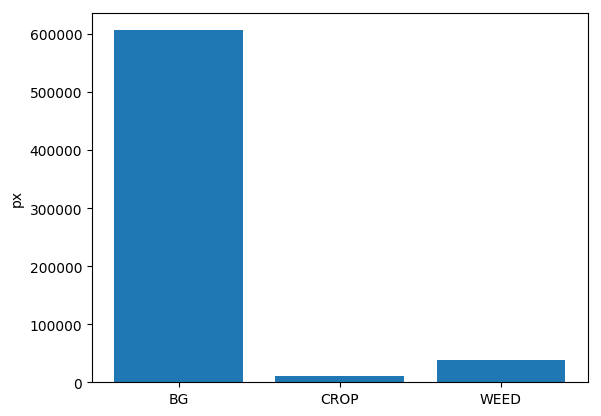

In [177]:
# calculate total pixel per label in train dataset

weed_pixel = 0
crop_pixel = 0
background_pixel = 0

for number in data["train"]:
    #桁あわせ　ex. 1 to 001
    number = "{0:03d}".format(number)

    #出力アノテーション画像の読み込み
    y_path = os.path.join("dataset-1.0","annotations",str(number)) + "_annotation.png" 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255

    #1の数を単純に積算することで領域を計算
    weed = img[:,:,0]
    _pixel = np.sum(weed.flatten())
    weed_pixel += _pixel 
    crop = img[:,:,1]
    _pixel = np.sum(crop.flatten())
    crop_pixel += _pixel

    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1) * 1
    _pixel = np.sum(back.flatten())
    background_pixel += _pixel


print(weed_pixel)
print(crop_pixel)
print(background_pixel)

plt.bar(["WEED","CROP","BG"],[weed_pixel,crop_pixel,background_pixel])
plt.ylabel("px")

In [178]:
#上述した値をもとにclass_weightを作成する（weed,crop,bgの順番）
#わかりやすいようにbackgroundを１とする

class_weight = [background_pixel/weed_pixel, background_pixel/crop_pixel, 1]
print(class_weight)

#つまり、weedとcropの領域で間違えるときの損失を16倍、59倍と補正をかける　

[15.786576796960391, 58.78621959492199, 1]


In [0]:
#ラベルごとに重みを調整できるcategorical crossentropy
#https://forums.fast.ai/t/unbalanced-classes-in-image-segmentation/18289/2
def weighted_categorical_crossentropy(weights):
    """ weighted_categorical_crossentropy

        Args:
            * weights<ktensor|nparray|list>: crossentropy weights
        Returns:
            * weighted categorical crossentropy function
    """
    if isinstance(weights,list) or isinstance(np.ndarray):
        weights=K.variable(weights)

    def loss(target,output,from_logits=False):
        if not from_logits:
            output /= tf.reduce_sum(output,
                                    len(output.get_shape()) - 1,
                                    True)
            _epsilon = tf.convert_to_tensor(K.epsilon(), dtype=output.dtype.base_dtype)
            output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
            weighted_losses = target * tf.log(output) * weights
            return - tf.reduce_sum(weighted_losses,len(output.get_shape()) - 1)
        else:
            raise ValueError('WeightedCategoricalCrossentropy: not valid with logits')
    return loss   

In [0]:
#モデルの再定義
K.clear_session()

#損失の定義
custom_loss = weighted_categorical_crossentropy(class_weight)

#pixel-wiseな正答率を出す簡便な方法
unet = small_Unet(labels=3,out_activation=None)  
l = layers.Reshape((128*128,3))(unet.output)
outs = layers.Activation("softmax")(l)

model = Model(inputs=unet.input,outputs=outs)

#model.compile(loss=dice_coef_multilabel,optimizer="rmsprop")
#model.compile(loss=tversky_loss,optimizer="rmsprop")
model.compile(loss=custom_loss,optimizer="rmsprop")

In [186]:
history = model.fit(train_x, train_y, batch_size=10, epochs=150, verbose=1,validation_data=(test_x,test_y))

Train on 40 samples, validate on 21 samples
Epoch 1/150
40/40 [==============================] - 2s 53ms/step - loss: 3.1062 - val_loss: 3.0365
Epoch 2/150
40/40 [==============================] - 1s 13ms/step - loss: 2.9287 - val_loss: 2.8388
Epoch 3/150
40/40 [==============================] - 0s 12ms/step - loss: 2.8287 - val_loss: 2.6926
Epoch 4/150
40/40 [==============================] - 0s 12ms/step - loss: 2.6586 - val_loss: 2.7824
Epoch 5/150
40/40 [==============================] - 1s 13ms/step - loss: 2.5271 - val_loss: 2.1136
Epoch 6/150
40/40 [==============================] - 1s 13ms/step - loss: 2.5431 - val_loss: 2.3124
Epoch 7/150
40/40 [==============================] - 1s 13ms/step - loss: 2.1101 - val_loss: 1.7715
Epoch 8/150
40/40 [==============================] - 1s 13ms/step - loss: 1.9425 - val_loss: 2.2209
Epoch 9/150
40/40 [==============================] - 1s 13ms/step - loss: 2.0387 - val_loss: 1.7268
Epoch 10/150
40/40 [==============================] - 1s

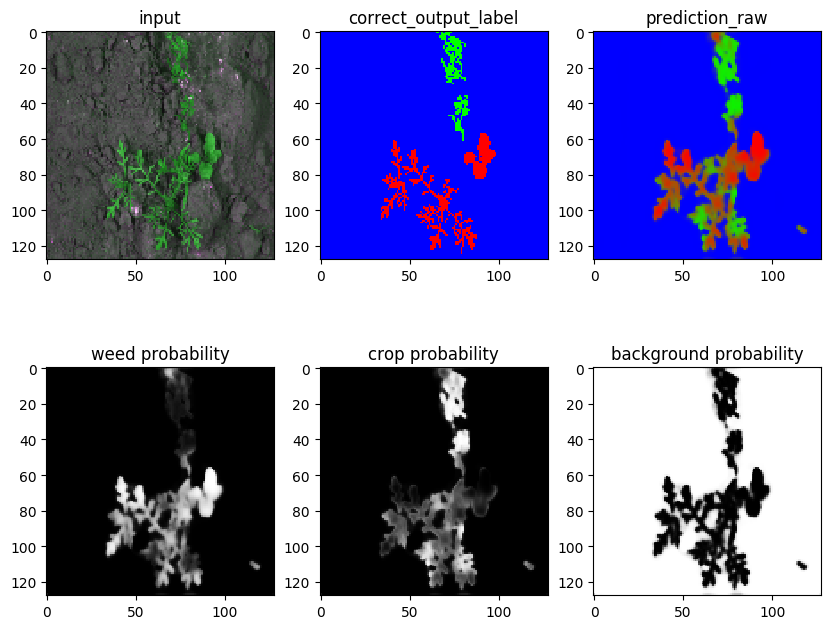

In [188]:
# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n = 3

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(2,3,2)
plt.title("correct_output_label")
img = np.reshape(test_y[n, :],(128,128,3))
plt.imshow(img)

prediction = model.predict(test_x[n:n+1])
prediction = np.reshape(prediction,(128,128,3))
plt.subplot(2,3,3)
plt.title("prediction_raw")
plt.imshow(prediction)


#per label
plt.subplot(2,3,4)
plt.title("weed probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 0 ,axis=-1)*1
plt.imshow(prediction[:,:,0],cmap="gray")

plt.subplot(2,3,5)
plt.title("crop probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 1 ,axis=-1)*1
plt.imshow(prediction[:,:,1],cmap="gray")

plt.subplot(2,3,6)
plt.title("background probability")
#img = prediction.copy()
#img = np.argmax(img,axis=2)
#img = np.all(img[...,np.newaxis] == 2 ,axis=-1)*1
plt.imshow(prediction[:,:,2],cmap="gray")